In [1]:
#standard libraries
import pickle
from os import listdir
import pandas as pd
import numpy

#word vec & ml libraries
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MiniBatchKMeans
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics.pairwise as smp
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import linear_kernel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.fftpack import fft
import numpy as np

#plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.pyplot import savefig
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
plt.rcParams['savefig.dpi'] = 144

In [2]:
df_authors = pd.read_csv('train.csv')

In [3]:
df_authors.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
df_authors.text[0]

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [5]:
#Sentiment Analysis

In [6]:
#Create Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()
sentiments = []

for sentence in df_authors.text:
    feeling = analyzer.polarity_scores(sentence)
    sentiments.append(feeling)

In [7]:
df_sentiments = pd.DataFrame(sentiments)
df_sentiments['author'] = df_authors.author
df_sentiments.head()

,compound,neg,neu,pos,author
0,0.6329,0.049,0.830,0.120,EAP
1,-0.3400,0.167,0.833,0.000,HPL
2,0.9246,0.033,0.661,0.306,EAP
3,0.9460,0.000,0.640,0.360,MWS
4,-0.8385,0.280,0.720,0.000,HPL


In [8]:
df_sentiments_avg = df_sentiments.groupby(['author']).mean()
df_sentiments_avg.reset_index(inplace = True)
df_sentiments_avg.columns = ['author', 'mean_compound', 'mean_neg', 'mean_neu', 'mean_pos']
df_sentiments_avg.head()

,author,mean_compound,mean_neg,mean_neu,mean_pos
0,EAP,0.042161,0.074389,0.839675,0.085936
1,HPL,-0.067880,0.091634,0.837867,0.070503
2,MWS,0.063381,0.103814,0.770362,0.125827


In [9]:
df_sentiments_std = df_sentiments.groupby(['author']).std()
df_sentiments_std.reset_index(inplace = True)
df_sentiments_std.columns = ['author', 'std_compound', 'std_neg', 'std_neu', 'std_pos']
df_sentiments_std.head()

,author,std_compound,std_neg,std_neu,std_pos
0,EAP,0.446034,0.106992,0.143468,0.112079
1,HPL,0.465087,0.102413,0.124763,0.089988
2,MWS,0.548786,0.119625,0.155729,0.129668


In [10]:
#Edgar Allen Poe
df_sentiments_eap = df_sentiments[df_sentiments['author'] == 'EAP']
print(len(df_sentiments_eap.author))
poe = len(df_sentiments_eap.author)
df_sentiments_eap.head()

7900


,compound,neg,neu,pos,author
0,0.6329,0.049,0.830,0.120,EAP
2,0.9246,0.033,0.661,0.306,EAP
6,0.0000,0.000,1.000,0.000,EAP
7,0.0000,0.000,1.000,0.000,EAP
8,0.8821,0.012,0.863,0.124,EAP


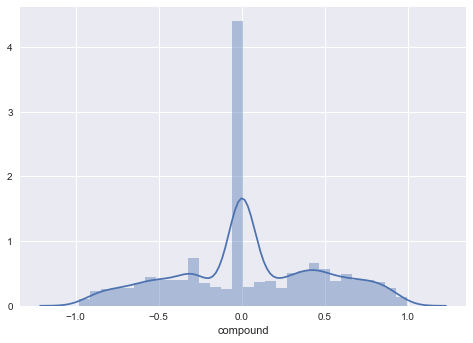

In [11]:
sns.distplot(df_sentiments_eap['compound'])

In [12]:
#HP Lovecraft
df_sentiments_hpl = df_sentiments[df_sentiments['author'] == 'HPL']
print(len(df_sentiments_hpl.author))
lovecraft = len(df_sentiments_hpl.author)
df_sentiments_hpl.head()

5635


,compound,neg,neu,pos,author
1,-0.3400,0.167,0.833,0.000,HPL
4,-0.8385,0.280,0.720,0.000,HPL
12,-0.4588,0.219,0.663,0.117,HPL
13,0.3612,0.000,0.848,0.152,HPL
19,0.9186,0.000,0.754,0.246,HPL


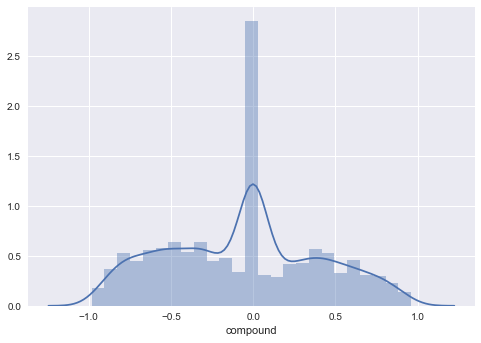

In [13]:
sns.distplot(df_sentiments_hpl['compound'])

In [14]:
#Mary Wolfenstone Shelley
df_sentiments_mws = df_sentiments[df_sentiments['author'] == 'MWS']
print(len(df_sentiments_mws.author))
shelley = len(df_sentiments_mws.author)
df_sentiments_mws.head()

6044


,compound,neg,neu,pos,author
3,0.9460,0.000,0.640,0.360,MWS
5,0.8714,0.073,0.757,0.170,MWS
9,0.4215,0.000,0.882,0.118,MWS
10,-0.7506,0.262,0.738,0.000,MWS
15,-0.2037,0.123,0.769,0.108,MWS


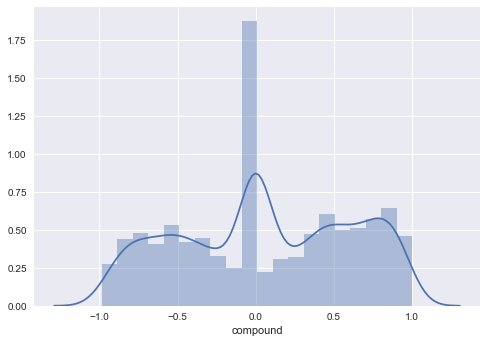

In [15]:
sns.distplot(df_sentiments_mws['compound'])

In [16]:
#Word Vector

In [17]:
stopWords = set(stopwords.words('english'))
tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), 
                            #stop_words=stopWords, 
                            max_df=1.0, min_df=1)

In [18]:
word_vec = tfidf_vec.fit_transform(df_authors.text)

In [19]:
pd.DataFrame(word_vec.todense(), 
             columns=tfidf_vec.get_feature_names()
            ).head()

,aaem,ab,ab not,ab not te,aback,aback by,aback by breeze,aback by reading,abaft,abaft the,...,élite of the,émeutes,émeutes the,émeutes the prefect,οἶδα,οἶδα know,οἶδα know know,οἶδα οἶδα,οἶδα οἶδα know,υπνος
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
cosine_similarities = linear_kernel(word_vec[2:3], word_vec).flatten()
cosine_similarities.shape

(19579,)

In [21]:
df_authors['cosine similarity'] = cosine_similarities
df_authors['compound'] = df_sentiments['compound']
df_authors['neg'] = df_sentiments['neg']
df_authors['neu'] = df_sentiments['neu']
df_authors['pos'] = df_sentiments['pos']
df_authors.head()

,id,text,author,cosine similarity,compound,neg,neu,pos
0,id26305,"This process, however, afforded me no means of...",EAP,0.005754,0.6329,0.049,0.830,0.120
1,id17569,It never once occurred to me that the fumbling...,HPL,0.000875,-0.3400,0.167,0.833,0.000
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,1.000000,0.9246,0.033,0.661,0.306
3,id27763,How lovely is spring As we looked from Windsor...,MWS,0.006017,0.9460,0.000,0.640,0.360
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,0.020319,-0.8385,0.280,0.720,0.000


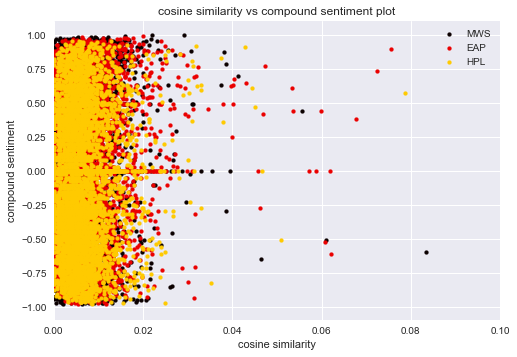

In [22]:
#Scatter of Petal
x=df_authors['cosine similarity']
y=df_authors['compound']

# Get unique names of species
uniq = list(set(df_authors['author']))

# Set the color map to match the number of species
z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# Plot each species
for i in range(len(uniq)):
    indx = df_authors['author'] == uniq[i]
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=uniq[i])

plt.xlabel('cosine similarity')
plt.ylabel('compound sentiment')
plt.title('cosine similarity vs compound sentiment plot')
plt.legend(loc='upper right')
plt.xlim([0, 0.1])
plt.show()

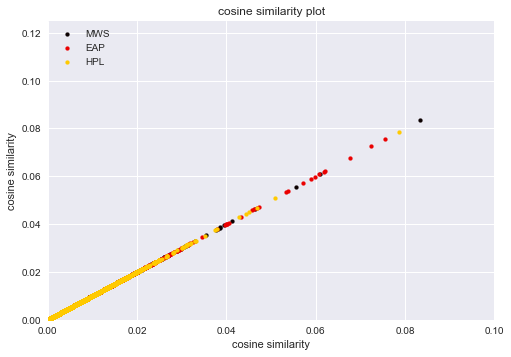

In [23]:
#Scatter of Petal
x=df_authors['cosine similarity']
y=df_authors['cosine similarity']

# Get unique names of species
uniq = list(set(df_authors['author']))

# Set the color map to match the number of species
z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# Plot each species
for i in range(len(uniq)):
    indx = df_authors['author'] == uniq[i]
    plt.scatter(x[indx], y[indx], s=15, color=scalarMap.to_rgba(i), label=uniq[i])

plt.xlabel('cosine similarity')
plt.ylabel('cosine similarity')
plt.title('cosine similarity plot')
plt.legend(loc='upper left')
plt.xlim([0, 0.1])
plt.ylim([0, 0.125])
plt.show()

In [24]:
df_pairs = df_authors.drop(['id', 'text'], axis = 1)
df_pairs.head()

,author,cosine similarity,compound,neg,neu,pos
0,EAP,0.005754,0.6329,0.049,0.830,0.120
1,HPL,0.000875,-0.3400,0.167,0.833,0.000
2,EAP,1.000000,0.9246,0.033,0.661,0.306
3,MWS,0.006017,0.9460,0.000,0.640,0.360
4,HPL,0.020319,-0.8385,0.280,0.720,0.000


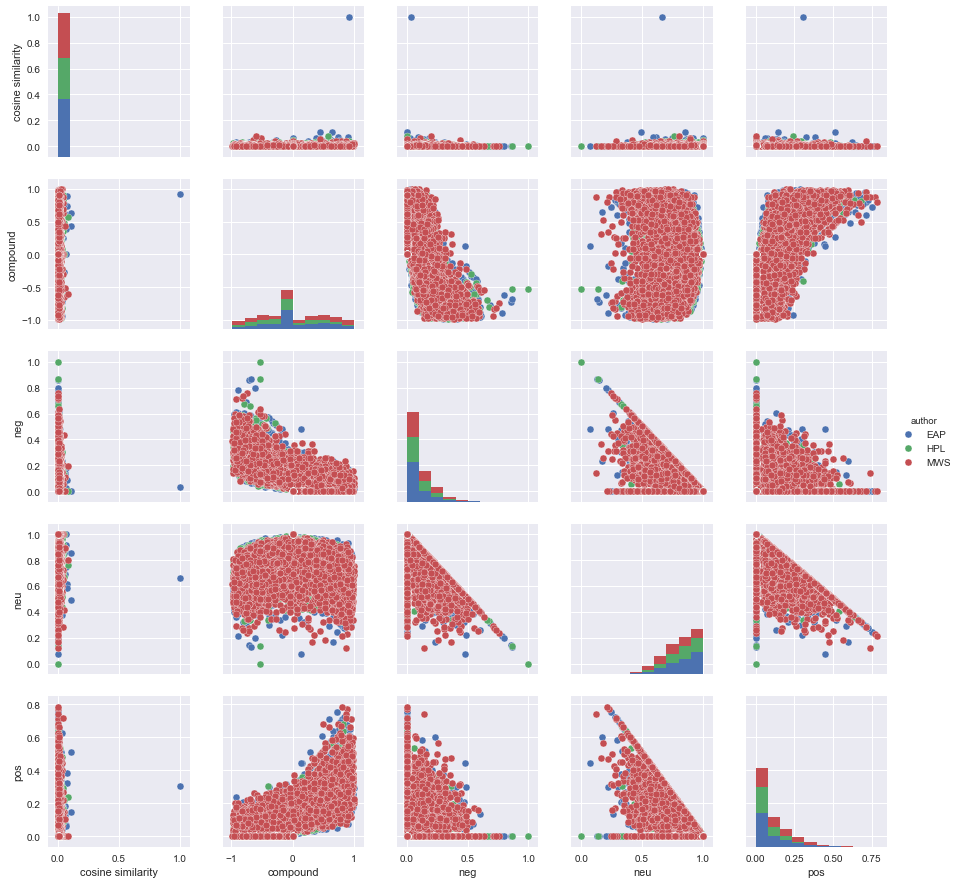

In [25]:
sns.pairplot(df_pairs, hue="author")

In [26]:
#author identification

In [27]:
stopWords = set(stopwords.words('english'))

In [28]:
authors_clf = Pipeline([('vect', CountVectorizer(stop_words=stopWords)),
                        ('tfidf', TfidfTransformer()),
                        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_authors.text, df_authors.author, test_size = 0.3)

In [30]:
y_train.value_counts()

EAP    5528
MWS    4243
HPL    3934
Name: author, dtype: int64

In [31]:
authors_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words={'until', '...     penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False))])

In [32]:
predicted = authors_clf.predict(X_train)

In [33]:
numpy.mean(predicted == y_train) 

0.84779277635899308

In [34]:
#set grid search parameters
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}

In [35]:
gs_clf = GridSearchCV(authors_clf, parameters, n_jobs=-1)

In [36]:
gs_clf = gs_clf.fit(X_train, y_train)
predictions = gs_clf.predict(X_train)

In [37]:
numpy.mean(predictions == y_train)

0.97322145202480848

In [38]:
cm = metrics.confusion_matrix(y_train, predictions, ['HPL', 'EAP', 'MWS'])
print(cm)

[[3783  137   14]
 [  19 5464   45]
 [  16  136 4091]]


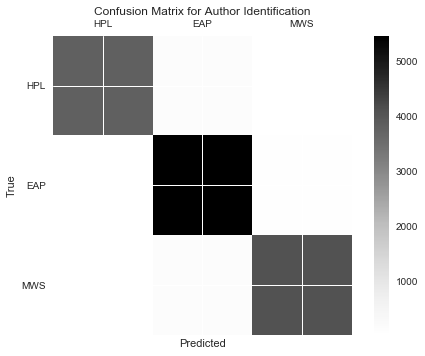

In [39]:
#nice plot of confusion matrix; class bias becomes clearly apparent
labels = ['HPL', 'EAP', 'MWS']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion Matrix for Author Identification')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [40]:
print('Poe: ' + str(y_train.value_counts()[0]) + '   ' + str(cm[1][1]/y_train.value_counts()[0]) +
     '\nLovecraft: ' + str(y_train.value_counts()[2]) + '   ' + str(cm[0][0]/y_train.value_counts()[2]) +
     '\nShelley: '+ str(y_train.value_counts()[1]) + '   ' + str(cm[2][2]/y_train.value_counts()[1]))

Poe: 5528   0.988422575977
Lovecraft: 3934   0.96161667514
Shelley: 4243   0.964176290361


In [41]:
#Test Training Model

In [42]:
gs_clf = gs_clf.fit(X_test, y_test)
predictions = gs_clf.predict(X_test)

In [43]:
numpy.mean(predictions == y_test)

0.98263534218590398

In [44]:
cm = metrics.confusion_matrix(y_test, predictions, ['HPL', 'EAP', 'MWS'])
print(cm)

[[1664   35    2]
 [   8 2356    8]
 [   6   43 1752]]


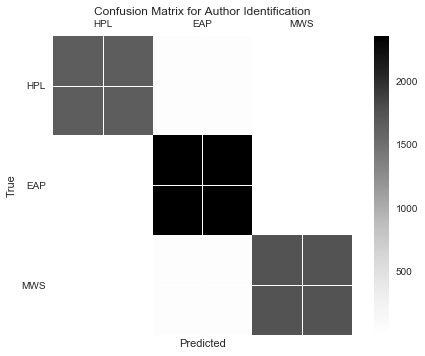

In [45]:
#nice plot of confusion matrix; class bias becomes clearly apparent
labels = ['HPL', 'EAP', 'MWS']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion Matrix for Author Identification')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [46]:
print('Poe: ' + str(y_test.value_counts()[0]) + '   ' + str(cm[1][1]/y_test.value_counts()[0]) +
     '\nLovecraft: ' + str(y_test.value_counts()[2]) + '   ' + str(cm[0][0]/y_test.value_counts()[2]) +
     '\nShelley: '+ str(y_test.value_counts()[1]) + '   ' + str(cm[2][2]/y_test.value_counts()[1]))

Poe: 2372   0.993254637437
Lovecraft: 1701   0.978248089359
Shelley: 1801   0.972792892837


In [47]:
#Submission

In [48]:
df_authors_test = pd.read_csv('test.csv')

In [49]:
df_authors_test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [50]:
submission = gs_clf.predict(df_authors_test.text)

In [51]:
print(submission)

['MWS' 'EAP' 'HPL' ..., 'EAP' 'MWS' 'EAP']


In [52]:
#New Model Log

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df_authors.text, df_authors.author, test_size = 0.3)

In [54]:
y_train.value_counts()

EAP    5493
MWS    4153
HPL    4059
Name: author, dtype: int64

In [55]:
stopWords = set(stopwords.words('english'))

In [56]:
authors_sgdc = Pipeline([('vect', CountVectorizer(stop_words=stopWords)),
                        ('tfidf', TfidfTransformer()),
                        ('sgdc', SGDClassifier(loss='modified_huber', penalty='l2',
                                           alpha=1e-3, random_state=42)),
])

In [57]:
authors_sgdc.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words={'until', '...     penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False))])

In [58]:
predicted = authors_sgdc.predict(X_train)

In [59]:
numpy.mean(predicted == y_train)

0.89740970448741331

In [60]:
#set grid search parameters
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'tfidf__use_idf': (True, False),
              'sgdc__alpha': (1e-2, 1e-3),
}

In [61]:
gs_sgdc = GridSearchCV(authors_sgdc, parameters, n_jobs=-1)

In [62]:
gs_sgdc = gs_sgdc.fit(X_train, y_train)
predictions = gs_sgdc.predict(X_train)

In [63]:
numpy.mean(predictions == y_train)

0.89740970448741331

In [64]:
predictions = gs_sgdc.predict(X_test)
numpy.mean(predictions == y_test)

0.79451821586653049

In [65]:
cm = metrics.confusion_matrix(y_test, predictions, ['HPL', 'EAP', 'MWS'])
print(cm)

[[1188  309   79]
 [ 153 2091  163]
 [ 139  364 1388]]


In [66]:
gs_sgdc.predict_proba(X_test)

array([[ 0.27185852,  0.60624754,  0.12189394],
       [ 0.64468336,  0.15460299,  0.20071365],
       [ 0.53610422,  0.23910752,  0.22478826],
       ..., 
       [ 0.30239717,  0.29772159,  0.39988124],
       [ 0.64349012,  0.15391156,  0.20259832],
       [ 0.41440875,  0.58559125,  0.        ]])

In [67]:
predictions

array(['HPL', 'EAP', 'EAP', ..., 'MWS', 'EAP', 'HPL'], 
      dtype='<U3')

In [71]:
i = 0
s = 0
labels = [0 for x in range(0,3)]
summary = gs_sgdc.predict_proba(X_test)

while s == 0:
    max_value = max(summary[i])
    max_index = list(summary[i]).index(max_value)
    labels[max_index] = predictions[i]
    i += 1
    
    if isinstance(labels[0], str) and isinstance(labels[1], str) and isinstance(labels[2], str):
        s = 1
        
summary = pd.DataFrame(summary)
summary.columns = labels
summary['Prediction'] = predictions
summary.head()

,EAP,HPL,MWS,Prediction
0,0.271859,0.606248,0.121894,HPL
1,0.644683,0.154603,0.200714,EAP
2,0.536104,0.239108,0.224788,EAP
3,0.149859,0.671126,0.179014,HPL
4,0.000000,0.060368,0.939632,MWS
